In [1]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
from scipy import optimize

In [2]:
dp = '/home/ebert/jupyter-notebooks/FNode-data'
exp_name = '2017_12_14_10_18_08_uwave-rfe'
exp_date = '_'.join(exp_name.split('_')[:3])
experiment_file = os.path.join(exp_date, exp_name, 'results.hdf5')
cuts = [[9],[2]]

q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
q.set_thresholds(cuts)

name 'fort_exp' is not defined


In [3]:
q.experiments[0]['variable_list']
xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']

In [4]:
retention = q.apply_thresholds()

In [5]:
tbl_str = "ivar:\t{0:.2f}\tretention:{1:.3f} +- {2:.3f}"
for i in range(len(retention['retention'].flatten())):
    print(tbl_str.format(
        retention['ivar'].flatten()[i],
        retention['retention'].flatten()[i],
        retention['error'].flatten()[i]
    ))

ivar:	0.00	retention:0.984 +- 0.005
ivar:	0.01	retention:0.960 +- 0.007
ivar:	0.02	retention:0.921 +- 0.010
ivar:	0.03	retention:0.807 +- 0.015
ivar:	0.03	retention:0.692 +- 0.017
ivar:	0.04	retention:0.520 +- 0.019
ivar:	0.05	retention:0.374 +- 0.018
ivar:	0.06	retention:0.291 +- 0.017
ivar:	0.07	retention:0.121 +- 0.012
ivar:	0.08	retention:0.041 +- 0.007
ivar:	0.09	retention:0.012 +- 0.004
ivar:	0.09	retention:0.010 +- 0.004
ivar:	0.10	retention:0.101 +- 0.011
ivar:	0.11	retention:0.172 +- 0.014
ivar:	0.12	retention:0.347 +- 0.018
ivar:	0.13	retention:0.443 +- 0.019
ivar:	0.14	retention:0.636 +- 0.018
ivar:	0.15	retention:0.727 +- 0.017
ivar:	0.15	retention:0.873 +- 0.013
ivar:	0.16	retention:0.949 +- 0.008
ivar:	0.17	retention:0.990 +- 0.004
ivar:	0.18	retention:0.966 +- 0.007
ivar:	0.19	retention:0.945 +- 0.009
ivar:	0.20	retention:0.834 +- 0.014
ivar:	0.21	retention:0.714 +- 0.017
ivar:	0.22	retention:0.560 +- 0.019
ivar:	0.22	retention:0.436 +- 0.019
ivar:	0.23	retention:0.272 +

In [6]:
q.save_experiment_data()

In [7]:
def rfe_nd_np(x, a, f, b):
    return b + a*np.cos(2*np.pi*f*x)

def rfe_nd(x, a, f, phi, b):
    return b + a*np.cos(2*np.pi*f*x+phi)

def rfe(x, a, f, phi, b, tau):
    return b + a*np.cos(2*np.pi*f*x+phi)*np.exp(-x/tau)

def rfe_pow(x, a, f, phi, b, tau, p):
    return b + a*np.cos(2*np.pi*f*x+phi)*np.exp(-np.power(x/tau,p))

<IPython.core.display.Javascript object>


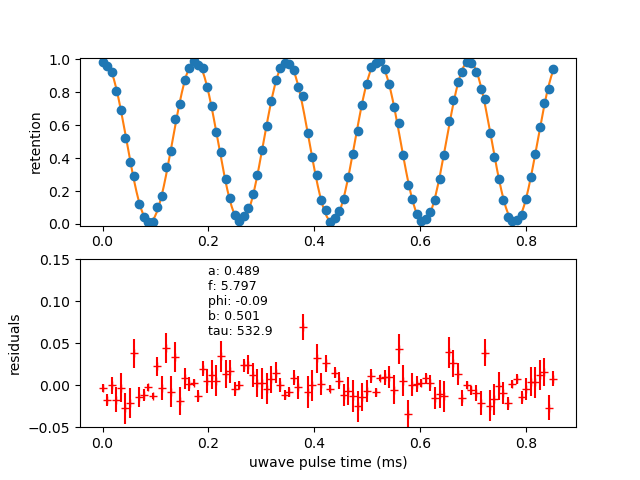

[  4.89029764e-01   5.79685897e+00  -9.20629219e-02   5.00840037e-01
   5.32926504e+02]


In [25]:
fig, ax = plt.subplots(2)
for e in range(len(retention['ivar'])):
    ax[0].errorbar(retention['ivar'][e], retention['retention'][e],
                yerr=retention['error'][e],
                fmt = 'o'
    )
ax[0].set_ylim(-0.01, 1.01)
ax[1].set_ylim(-0.05, 0.15)

ax[1].set_xlabel(xlab)

guess = [0.45, 5.7, 0, 0.5, 10]
for e in range(len(retention['ivar'])):
    popt, pcov = optimize.curve_fit(
        rfe,
        retention['ivar'][e],
        retention['retention'][e],
        p0=guess,
        sigma=retention['error'][e]
    )
    xs = np.linspace(min(retention['ivar'][e]),max(retention['ivar'][e]),200)
    ax[0].plot(xs, rfe(xs, *popt))
    fit_data = "a: {:.3f}\nf: {:.3f}\nphi: {:.2f}\nb: {:.3f}\ntau: {:.1f}"
    ax[1].text(0.2, 0.06, fit_data.format(*popt), fontsize=9)

ax[0].set_ylabel('retention')
ax[1].set_ylabel('residuals')
residuals = retention['retention'][e] - rfe(retention['ivar'][0], *popt)
#residuals /= np.power(retention['error'][e], 2)
ax[1].errorbar(retention['ivar'][0], residuals, yerr=retention['error'][e], fmt='r+')

print(popt)
fmts = ['pdf', 'png']
fn = os.path.join(dp, os.path.dirname(experiment_file), 'rfe_retention_fit.{}')
for fmt in fmts:
    fig.savefig(fn.format(fmt), dpi=200, format=fmt)

In [9]:
0.5/popt[1]

0.086633551454501995

In [10]:
print(popt[2] - popt[0])
print(popt[2] + popt[0])

0.0122310873836
0.990801027416


In [11]:
(0.5 - popt[2]/(2*np.pi))/popt[1]

0.072803586225125769

In [27]:
9.5*(0.5/popt[1])

0.81940927359216886